# MOwNiT 
## Laboratorium 5 - Macierze i aproksymacja

## Zadania 

In [1]:
using DataFrames, Statistics, Plots, Plots.PlotMeasures, TaylorSeries, Polynomials, CSV

### Zadanie 1 (1 p) 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`)

dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)


In [2]:
# Wklejone z oryginalnego notebooka

function naive_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

In [3]:
struct Row
    implementation::String
    size::Int64
    time::Float64
end

In [4]:
# "Rozgrzanie"
mat_size = 300
A = rand(Float64, mat_size, mat_size)
B = rand(Float64, mat_size, mat_size)
_ = naive_multiplication(A, B)
_ = better_multiplication(A, B)
A*B

rows = Row[]

for mat_size in 50:50:800
    for _ in 1:10
        A = rand(Float64, mat_size, mat_size)
        B = rand(Float64, mat_size, mat_size)

        _, naive_time = @timed naive_multiplication(A, B)
        _, better_time = @timed better_multiplication(A, B)
        _, blas_time = @timed A*B
        
        push!(rows, Row("Naive", mat_size, naive_time))
        push!(rows, Row("Better", mat_size, better_time))
        push!(rows, Row("BLAS", mat_size, blas_time))
    end
    println("Size ", mat_size, " done!")
end

df = DataFrame(rows)

df

Size 50 done!
Size 100 done!
Size 150 done!
Size 200 done!
Size 250 done!
Size 300 done!
Size 350 done!
Size 400 done!
Size 450 done!
Size 500 done!
Size 550 done!
Size 600 done!
Size 650 done!
Size 700 done!
Size 750 done!
Size 800 done!


Row,implementation,size,time
,String,Int64,Float64
1,Naive,50,0.000132303
2,Better,50,0.000107831
3,BLAS,50,2.4664e-5
4,Naive,50,0.000123986
5,Better,50,0.000105006
6,BLAS,50,9.013e-6
7,Naive,50,0.000115813
8,Better,50,0.000114328
9,BLAS,50,4.141e-6


In [5]:
result = sort(combine(groupby(df, [:implementation, :size]), 
                 :time => (time -> mean(time)) => :mean, 
                 :time => (time -> std(time)) => :std
), [:size])

Row,implementation,size,mean,std
,String,Int64,Float64,Float64
1,Naive,50,0.000114834,7.7547e-6
2,Better,50,0.000109308,3.2061e-6
3,BLAS,50,6.6149e-6,6.5335e-6
4,Naive,100,0.00103376,2.57535e-5
5,Better,100,0.00092783,2.57869e-5
6,BLAS,100,9.66691e-5,9.46715e-6
7,Naive,150,0.0072499,0.003554
8,Better,150,0.0470044,0.0460721
9,BLAS,150,0.0238128,0.0391708


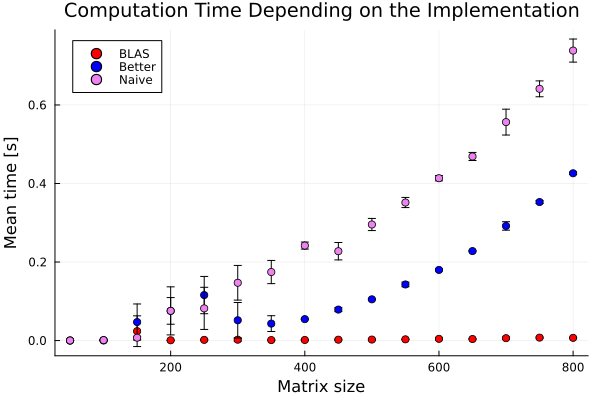

In [6]:
scatter(
    result.size, 
    result.mean, 
    group=result.implementation, 
    yerror=result.std, 
    color=[:red :blue :violet],
    titlefont=font(13),
    title="Computation Time Depending on the Implementation",
    xlabel="Matrix size", 
    ylabel="Mean time [s]",
)

### Zadanie 2 (2 p) 
Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    
Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
    
Do analizy danych można użyć wybranego narzędzia (Julia, R)
    
*(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 


## Implementacja

### Przygotowujemy odpowiednie biblioteki:

```c
#include <gsl/gsl_sf_bessel.h>
#include <gsl/gsl_blas.h>
#include <stdio.h>
#include <time.h>

```

### Definiujemy funkcje mnożące:

```c
void naive_multiplication(double **A, double **B, double **C, int size) {
    for (int i = 0; i < size; i++) {
        for (int j = 0; j < size; j++) {
            for (int k = 0; k < size; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

void better_multiplication(double **A, double **B, double **C, int size) {
    for (int i = 0; i < size; i++) {
        for (int k = 0; k < size; k++) {
            for (int j = 0; j < size; j++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

void blas_multiplication(double *a, double *b, double *c, int n) {
    gsl_matrix_view A = gsl_matrix_view_array(a, n, n);
    gsl_matrix_view B = gsl_matrix_view_array(b, n, n);
    gsl_matrix_view C = gsl_matrix_view_array(c, n, n);

    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &A.matrix, &B.matrix, 0.0, &C.matrix);
}
```

### Kilka przydatnych funkcji:

```c
void fill_rand(double **A, int size) {
    for (int i = 0; i < size; i++) {
        for (int j = 0; j < size; j++) {
            A[i][j] = rand() % 10;
        }
    }
}

void flatten(double **A, double *a, int size) {
    for (int k = 0; k < size * size; k++) {
        a[k] = A[k / size][k % size];
    }
}

void free_matrix(double **A, int size) {
    for (int i = 0; i < size; i++) {
        free(A[i]);
    }

    free(A);
}

double **alloc_matrix(int size) {
    double **A = malloc(size * sizeof(double *));
    for (int i = 0; i < size; i++) {
        A[i] = malloc(size * sizeof(double));
    }

    return A;
}
```

### Główne przetwarzanie:

```c
void process_with_size(int size) {
    double **A, **B, **C;
    double *a, *b, *c;

    a = malloc(size * size * sizeof(double));
    b = malloc(size * size * sizeof(double));
    c = malloc(size * size * sizeof(double));
    A = alloc_matrix(size);
    B = alloc_matrix(size);
    C = alloc_matrix(size);

    for (int x = 0; x < 10; x++) {
        fill_rand(A, size);
        fill_rand(B, size);

        clock_t start = clock();
        naive_multiplication(A, B, C, size);
        printf("%d,%s,%f\n", size, "Naive", (double)(clock() - start) / CLOCKS_PER_SEC);

        start = clock();
        better_multiplication(A, B, C, size);
        printf("%d,%s,%f\n", size, "Better", (double)(clock() - start) / CLOCKS_PER_SEC);

        flatten(A, a, size);
        flatten(B, b, size);

        start = clock();
        blas_multiplication(a, b, c, size);
        printf("%d,%s,%f\n", size, "BLAS", (double)(clock() - start) / CLOCKS_PER_SEC);
    }

    free(a);
    free(b);
    free(c);
    free_matrix(A, size);
    free_matrix(B, size);
    free_matrix(C, size);
}
```

### Funkcja `main`

```c
int main() {
    for (int size = 50; size <= 500; size += 50) {
        process_with_size(size);
    }

    return 0;
}
```

### `Makefile`

```
build:
	@gcc main.c -Wall -Wextra -Wpedantic -o main -lgsl -lgslcblas -lm

bench: bu
    @ echo "implementation,size,time" > results.csvild 
	@./main > results.csv

clean:
	- @rm main results.csv
```

Po wywołaniu `make bench` powstanie plik `results.csv` z wynikami

## Analiza

In [8]:
df = CSV.read("results.csv", DataFrame)

Row,size,implementation,time
,Int64,String7,Float64
1,50,Naive,0.000372
2,50,Better,0.000348
3,50,BLAS,6.3e-5
4,50,Naive,0.000367
5,50,Better,0.00034
6,50,BLAS,3.5e-5
7,50,Naive,0.000365
8,50,Better,0.000338
9,50,BLAS,3.5e-5


In [9]:
res = sort(combine(groupby(df, [:implementation, :size]), 
                 :time => (time -> mean(time)) => :mean, 
                 :time => (time -> std(time)) => :std
), [:size])

Row,implementation,size,mean,std
,String7,Int64,Float64,Float64
1,Naive,50,0.0003714,1.01127e-5
2,Better,50,0.0003436,3.30656e-6
3,BLAS,50,3.87e-5,8.56414e-6
4,Naive,100,0.0029913,7.00842e-5
5,Better,100,0.0028751,0.000130505
6,BLAS,100,0.0003221,1.86991e-5
7,Naive,150,0.0100906,7.69144e-5
8,Better,150,0.009645,9.24842e-5
9,BLAS,150,0.0010595,0.000151045


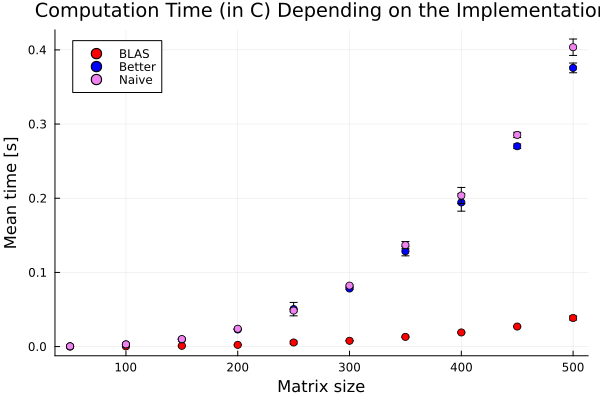

In [10]:
scatter(
    res.size, 
    res.mean, 
    group=res.implementation, 
    yerror=res.std, 
    color=[:red :blue :violet],
    titlefont=font(13),
    title="Computation Time (in C) Depending on the Implementation",
    xlabel="Matrix size", 
    ylabel="Mean time [s]",
)

### Zadanie 3 (1 p) 
Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

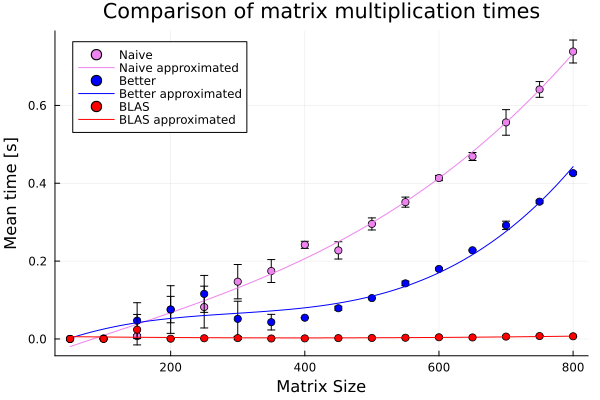

In [7]:
plot_result = plot()

function fit_and_plot(df, fit_degree, color, plot)
    fitted = fit(df.size, df.mean, fit_degree)
    xs = 50:1:800
    scatter!(df.size, df.mean, label = df.implementation[1], color = color, yerror=df.std)
    plot!(fitted, extrema(xs)..., label = df.implementation[1] * " approximated", color = color)
end


grouped = groupby(result, :implementation)


colors = [:violet, :blue, :red]
for (i, group) in enumerate(grouped)
    if group.implementation[1] == "BLAS"
        fit_and_plot(group, 2, colors[i], plot_result)
    else
        fit_and_plot(group, 3, colors[i], plot_result)
    end
end

plot!(
    plot_result,
    xlabel = "Matrix Size",
    ylabel = "Mean time [s]",
    title = "Comparison of matrix multiplication times",
)

display(plot_result)

Złożoność metod "naive" oraz "better" wynosi O(n^3), dlatego dopasowałem wielomian 3 stopnia.
W odniesieniu do metody BLAS znalazłem następujące informacje:

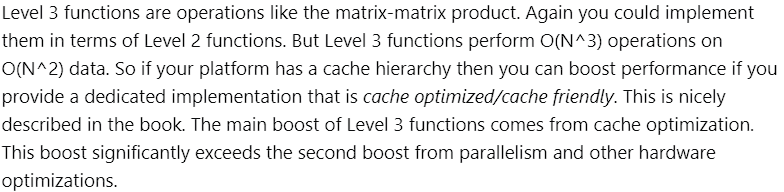

Co pozwoliło na optymistyczne oszacowanie złożoności na O(n^2), przez co dopasowany został wielomian 2 stopnia.

### Zadanie 4 (1 p) 
Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres.

### Zadanie 5 (1 p)
Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ 

Skorzystamy z funkcji pokazanej w powyższym artykule:

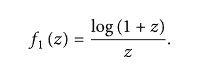

In [8]:
function func(x)
    log(1 + x) / x
end

func (generic function with 1 method)

In [9]:
taylor_series = func(Taylor1(Float64, 5))
taylor = Polynomial(taylor_series.coeffs)

Polynomial(1.0 - 0.5*x + 0.3333333333333333*x^2 - 0.25*x^3 + 0.2*x^4)

Powyższy wynik zgadza się z artykułem:

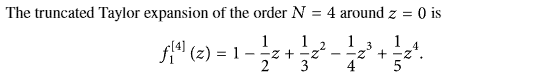

In [10]:
pade = Polynomials.PolyCompat.PadeApproximation.Pade(taylor, 2, 2)
display(pade.p)
display(pade.q)

Polynomial(1.0 + 0.6999999999999987*x + 0.03333333333333298*x^2)

Polynomial(1.0 + 1.1999999999999986*x + 0.29999999999999905*x^2)

Wynik powyżej również pokrywa się z artykułem:

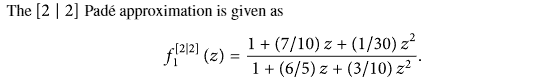

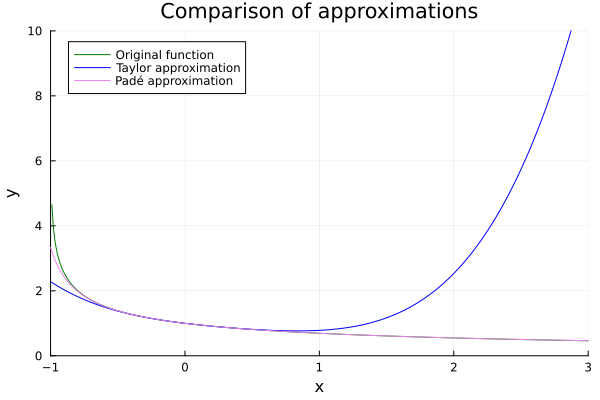

In [11]:
xsf = -1:0.01:4
ys_func = [func(x) for x in xsf]
ys_taylor = [taylor(x) for x in xsf]
ys_pade = [pade(x) for x in xsf]

plot(
    xlabel = "x",
    ylabel = "y",
    ylims = [0, 10],
    xlims = [-1, 3],
    title = "Comparison of approximations",
    color = :green,
)

plot!(xsf, ys_func, label = "Original function", color = :green)
plot!(xsf, ys_taylor, label = "Taylor approximation", color = :blue)
plot!(xsf, ys_pade, label = "Padé approximation", color = :violet)